# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import copy
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
from matplotlib.colors import SymLogNorm

from minot.ClusterTools import map_tools
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
#----- SZ data
dat_dir     = os.getenv('CTAPHYS_EDAT_DIR')
ymap_file   = dat_dir+'/Planck/COM_CompMap_Compton-SZMap-milca-ymaps_2048_R2.00.fits'
FWHM_planck = 10.0*u.arcmin
ymap_SM     = 1*u.arcmin
yprof_reso  = 5*u.arcmin
ymap_fov    = 6*u.deg
ymap_reso   = 2.5*u.arcmin

#----- X data
xmap_file      = dat_dir+'/ROSAT/RASS_1_2048.fits'
xmap_sp_file   = dat_dir+'/ROSAT/spectrum.sp'
xmap_resp_file = dat_dir+'/ROSAT/pspcb_gain1_256.rsp'
xmap_nh_file   = dat_dir+'/ROSAT/HI_LAB_II_1_256_nh.fits'
xmap_band      = [0.1*u.keV, 2.4*u.keV]
FWHM_rass      = 1.8*u.arcmin
xmap_SM        = 1*u.arcmin
xprof_reso     = 1*u.arcmin
xmap_fov       = 6*u.deg
xmap_reso      = 0.5*u.arcmin
xmap_coeff     = 5.24559/(hp.nside2resol(2048, arcmin=True)**2)

#----- Various
NFWHMmask = 3
NR500ZL = 3
src1 = SkyCoord("3h19m48.16s +41d30m42s", frame='icrs')              # NGC1275
src2 = SkyCoord(48.25948051*u.deg, +41.35073379*u.deg, frame='icrs') # as the peak of the map
FWHM2sigma = 1.0/(2.0*np.sqrt(2*np.log(2)))
outdir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Define the models

### Common parameters

In [3]:
NR500_trunc = 3
redshift    = 0.017284
M500        = 6.2e14*u.Msun
RA          = 49.94666667*u.deg
Dec         = 41.51305556*u.deg

In [4]:
theta_ref = 20*u.arcmin

### Cosmological correction

In [64]:
cor_ett1999 = 50.0/cosmo.H0.to_value('km s-1 Mpc-1')
cor_chu2003 = 50.0/cosmo.H0.to_value('km s-1 Mpc-1')
cor_urb2014 = 70.0/cosmo.H0.to_value('km s-1 Mpc-1')
rescal_urb2014 = 0.9
cor_ett1999, cor_chu2003, cor_urb2014

(0.7381163271331562, 0.7381163271331562, 1.0333628579864187)

### Churazov et al. (2003) n and T

In [6]:
C1 = minot.Cluster(name='Churazov_Nall_Tall', redshift=redshift, M500=M500, RA=RA, Dec=Dec, cosmology=cosmo, silent=True, output_dir=outdir)
C1.R_truncation = NR500_trunc*C1.R500

C1.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                                  'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
radius = np.logspace(0,5,1000)*u.kpc
T_e = 7.0*(1+(radius.to_value('kpc')/(100.0*0.73))**3)/(2.3+(radius.to_value('kpc')/(100.0*0.73))**3)*u.keV
radius, n_e = C1.get_density_gas_profile(radius)
P_e = n_e*T_e
C1.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

### Churazov et al. (2003) n core + Urban et al. (2014) n out and P

In [7]:
#---------- Cluster definition
C2 = minot.Cluster(name='Churazov_Nin_Urban_Nout_Pout', redshift=redshift, M500=M500, RA=RA, Dec=Dec, cosmology=cosmo, silent=True, output_dir=outdir)
C2.R_truncation = NR500_trunc*C2.R500

#---------- Merge Churazov and Urban density profiles
# Total Churazov 2003 density
C2.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref1 = C2.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C2.redshift))
# Outskirt Churazov 2003 density
C2.density_gas_model = {'name':'beta', 'beta':0.58, 'r_c':280*u.kpc*cor_chu2003, 'n_0':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref2 = C2.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C2.redshift))
# Urban 2014 normalized density
C2.density_gas_model = {'name':'beta', 'beta':0.71, 'r_c':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(C2.redshift), 'n_0':1*u.cm**-3*cor_urb2014**-0.5}
bid, nref3 = C2.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C2.redshift))
# Merge the two unsuring consistency
C2.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.71, 'r_c2':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(C2.redshift), 'n_02':rescal_urb2014*(nref2/nref3).to_value('')*1*u.cm**-3*cor_urb2014**-0.5}
bid, nref4 = C2.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C2.redshift))

#---------- Set the pressure
ctmp = copy.deepcopy(C2)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
pgasmod = ctmp.pressure_gas_model
del pgasmod['c500']
C2.pressure_gas_model = pgasmod

### Churazov et al. (2003) n core + Ettori et al. (1999) n out + Urban et al. (2014) P

In [8]:
#---------- Cluster definition
C3 = minot.Cluster(name='Churazov_Nin_Ettori_Nout_Urban_Pout', redshift=redshift, M500=M500, RA=RA, Dec=Dec, cosmology=cosmo, silent=True, output_dir=outdir)
C3.R_truncation = NR500_trunc*C3.R500

#---------- Merge Churazov and Urban density profiles
# Total Churazov 2003 density
C3.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref1 = C3.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C3.redshift))
# Outskirt Churazov 2003 density
C3.density_gas_model = {'name':'beta', 'beta':0.58, 'r_c':280*u.kpc*cor_chu2003, 'n_0':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref2 = C3.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C3.redshift))
# Ettori 1999 normalized density
C3.density_gas_model = {'name':'beta', 'beta':0.81, 'r_c':17.0*u.arcmin*cosmo.kpc_proper_per_arcmin(C3.redshift), 'n_0':1*u.cm**-3*cor_ett1999**-0.5}
bid, nref3 = C3.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C3.redshift))
# Merge the two unsuring consistency
C3.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.81, 'r_c2':17*u.arcmin*cosmo.kpc_proper_per_arcmin(C3.redshift), 'n_02':(nref2/nref3).to_value('')*1*u.cm**-3*cor_ett1999**-0.5}
bid, nref4 = C3.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C3.redshift))

#---------- Set the pressure
ctmp = copy.deepcopy(C3)
ctmp.theta500 = 59.7*u.arcmin
ctmp.set_pressure_gas_gNFW_param('P13UPP')
pgasmod = ctmp.pressure_gas_model
del pgasmod['c500']
C3.pressure_gas_model = pgasmod

### Churazov et al. (2003) n core + Urban et al. (2014) n & T outskirt

In [9]:
C4 = minot.Cluster(name='Churazov_Nin_Urban_Nout_Tout', redshift=redshift, M500=M500, RA=RA, Dec=Dec, cosmology=cosmo, silent=True, output_dir=outdir)
C4.R_truncation = NR500_trunc*C4.R500

#---------- Merge Churazov and Urban density profiles
# Total Churazov 2003 density
C4.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref1 = C4.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C4.redshift))
# Outskirt Churazov 2003 density
C4.density_gas_model = {'name':'beta', 'beta':0.58, 'r_c':280*u.kpc*cor_chu2003, 'n_0':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref2 = C4.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C4.redshift))
# Urban 2014 normalized density
C4.density_gas_model = {'name':'beta', 'beta':0.71, 'r_c':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(C4.redshift), 'n_0':1*u.cm**-3*cor_urb2014**-0.5}
bid, nref3 = C4.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C4.redshift))
# Merge the two unsuring consistency
C4.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.71, 'r_c2':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(C4.redshift), 'n_02':rescal_urb2014*(nref2/nref3).to_value('')*1*u.cm**-3*cor_urb2014**-0.5}
bid, nref4 = C4.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C4.redshift))

#---------- Urban temperature profile
radius = np.logspace(0,5,1000)*u.kpc
T_e = 4.06*u.keV*((radius.to_value('kpc')/294)**6.72+0.72)/(1+(radius.to_value('kpc')/294)**6.72)*((radius.to_value('Mpc')/1.6)**-0.33)/(1+(radius.to_value('Mpc')/1.6)**16.24)**(2.36/16.24)
n_e = C4.get_density_gas_profile(radius)[1]
P_e = n_e*T_e
C4.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

### Churazov et al. (2003) n & T core + Urban et al. (2014) n & T outskirt

In [63]:
C5 = minot.Cluster(name='Churazov_Nin_Tin_Urban_Nout_Tout', redshift=redshift, M500=M500, RA=RA, Dec=Dec, cosmology=cosmo, silent=True, output_dir=outdir)
C5.R_truncation = NR500_trunc*C5.R500

#---------- Merge Churazov and Urban density profiles
# Total Churazov 2003 density
C5.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.58, 'r_c2':280*u.kpc*cor_chu2003, 'n_02':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref1 = C5.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C5.redshift))
# Outskirt Churazov 2003 density
C5.density_gas_model = {'name':'beta', 'beta':0.58, 'r_c':280*u.kpc*cor_chu2003, 'n_0':4.05e-3*u.cm**-3*cor_chu2003**-0.5}
bid, nref2 = C5.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C5.redshift))
# Urban 2014 normalized density
C5.density_gas_model = {'name':'beta', 'beta':0.71, 'r_c':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(C5.redshift), 'n_0':1*u.cm**-3*cor_urb2014**-0.5}
bid, nref3 = C5.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C5.redshift))
# Merge the two unsuring consistency
C5.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':80*u.kpc*cor_chu2003, 'n_01':3.9e-2*u.cm**-3*cor_chu2003**-0.5,
                        'beta2':0.71, 'r_c2':13.18*u.arcmin*cosmo.kpc_proper_per_arcmin(C5.redshift), 'n_02':rescal_urb2014*(nref2/nref3).to_value('')*1*u.cm**-3*cor_urb2014**-0.5}
bid, nref4 = C5.get_density_gas_profile(theta_ref*cosmo.kpc_proper_per_arcmin(C5.redshift))

#---------- Churazov+Urban temperature profile
radius = np.logspace(0,5,1000)*u.kpc
T_e = 7.0*(1+(radius.to_value('kpc')/(100.0*0.73))**3)/(2.3+(radius.to_value('kpc')/(100.0*0.73))**3)*u.keV * (1+(radius.to_value('Mpc')/1.6)**1.7)**-(2.0/2)
n_e = C5.get_density_gas_profile(radius)[1]
P_e = n_e*T_e
C5.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

[0.00383101] 1 / cm3


#### List models

In [11]:
Clist = [C1,C2,C3,C4,C5]

# Model to model comparison

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


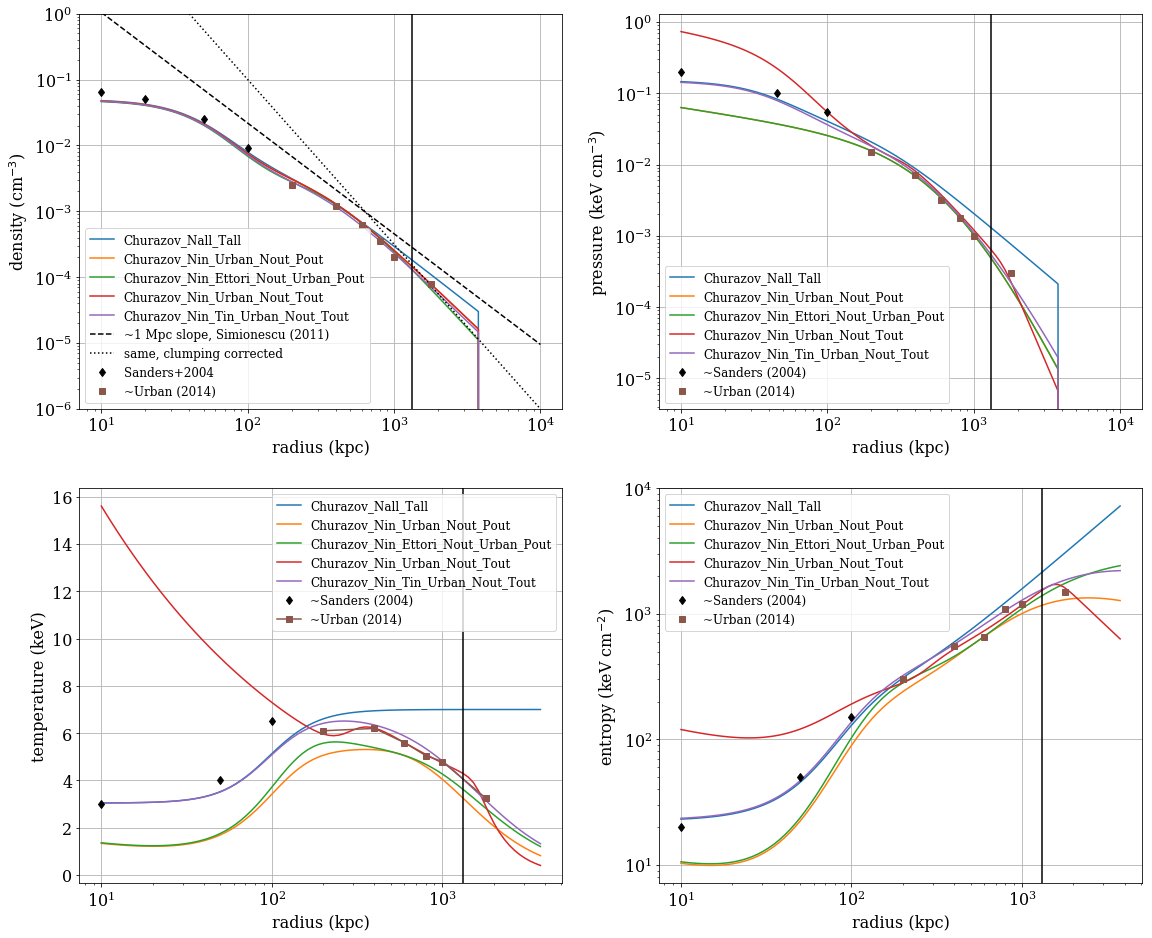

In [12]:
r = np.logspace(1,4,100)*u.kpc

fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
for C in Clist:
    r,n = C.get_density_gas_profile(r)
    plt.loglog(r,n, label=C.name)
plt.loglog(r, 50*r**-1.68, linestyle='--', color='k', label='~1 Mpc slope, Simionescu (2011)')
plt.loglog(r, 10000*r**-2.50, linestyle=':', color='k', label='same, clumping corrected')
plt.loglog([10,20,50,100], [0.065,0.05,0.025,0.009], marker='d', linestyle='', color='k', label='Sanders+2004')
plt.plot([200,400,600,800,1000,1800], [0.0025,0.0012,0.00062,0.00035,0.0002,0.00008], marker='s', linestyle='', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('density (cm$^{-3}$)')
plt.ylim(1e-6,1e0)
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(222)
for C in Clist:
    r,p = C.get_pressure_gas_profile(r)
    plt.loglog(r,p, label=C.name)
plt.loglog([10,45,100], [0.2,0.1,0.055], marker='d', linestyle='', color='k', label='~Sanders (2004)')
plt.plot([200,400,600,800,1000,1800], [0.015,0.0072,0.0032,0.0018,0.001,0.0003], marker='s', linestyle='', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('pressure (keV cm$^{-3}$)')
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(223)
for C in Clist:
    r,t = C.get_temperature_gas_profile(r)
    plt.plot(r,t, label=C.name)
plt.plot([10,50,100], [3,4,6.5], marker='d', linestyle='', color='k', label='~Sanders (2004)')
plt.plot([200,400,600,800,1000,1800], [6.1,6.2,5.6,5.05,4.8,3.25], marker='s', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xscale('log')
plt.xlabel('radius (kpc)')
plt.ylabel('temperature (keV)')
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(224)
for C in Clist:
    r,k = C.get_entropy_gas_profile(r)
    plt.loglog(r,k, label=C.name)
plt.loglog([10,50,100], [20,50,150], marker='d', linestyle='', color='k', label='~Sanders (2004)')
plt.plot([200,400,600,800,1000,1800], [300,550,650,1100,1200,1500], marker='s', linestyle='', label='~Urban (2014)')
plt.axvline(C1.R500.to_value('kpc'), color='k')
plt.xlabel('radius (kpc)')
plt.ylabel('entropy (keV cm$^{-2}$)')
plt.legend(fontsize=12)
plt.grid()

In [13]:
print('----- Uth500 -----')
for C in Clist:
    print(C.name+': '+str(C.get_thermal_energy_profile(radius=C.R500)[1][0]))

print('----- Uth(Rtrunc) -----')
for C in Clist:
    print(C.name+': '+str(C.get_thermal_energy_profile(radius=C.R_truncation)[1][0]))

----- Uth500 -----
Churazov_Nall_Tall: 3.51960992754e+63 erg
Churazov_Nin_Urban_Nout_Pout: 2.08255959985e+63 erg
Churazov_Nin_Ettori_Nout_Urban_Pout: 2.08255959985e+63 erg
Churazov_Nin_Urban_Nout_Tout: 2.48168958632e+63 erg
Churazov_Nin_Tin_Urban_Nout_Tout: 2.26193966176e+63 erg
----- Uth(Rtrunc) -----
Churazov_Nall_Tall: 1.40814952904e+64 erg
Churazov_Nin_Urban_Nout_Pout: 3.85094907417e+63 erg
Churazov_Nin_Ettori_Nout_Urban_Pout: 3.85094907417e+63 erg
Churazov_Nin_Urban_Nout_Tout: 4.16038940306e+63 erg
Churazov_Nin_Tin_Urban_Nout_Tout: 4.37195449411e+63 erg


In [75]:
for C in Clist:
    C.make_xspec_table(Emin=0.1*u.keV, Emax=2.4*u.keV, Tmin=0.1*u.keV, Tmax=15.0*u.keV, nbin=10,file_HI=xmap_nh_file, visu_nH=False, model='APEC',resp_file=xmap_resp_file, data_file=xmap_sp_file, app_nH_model=False)
    print('within R500: '+C.name+': '+str((C.get_xray_flux(Rmax=C.R500, type_integral='spherical', output_type='S')*(4*np.pi*C.D_lum**2)).to('erg s-1')))
    print('within Rtrunc: '+C.name+': '+str((C.get_xray_flux(Rmax=C.R_truncation, type_integral='spherical', output_type='S')*(4*np.pi*C.D_lum**2)).to('erg s-1')))

<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
within R500: Churazov_Nall_Tall: 8.67088665639e+44 erg / s
within Rtrunc: Churazov_Nall_Tall: 1.04788332219e+45 erg / s
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
within R500: Churazov_Nin_Urban_Nout_Pout: 8.70800522412e+44 erg / s
within Rtrunc: Churazov_Nin_Urban_Nout_Pout: 9.73940522322e+44 erg / s
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
within R500: Churazov_Nin_Ettori_Nout_Urban_Pout: 7.87663091993e+44 erg / s
within Rtrunc: Churazov_Nin_Ettori_Nout_Urban_Pout: 8.50935552474e+44 erg / s
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
within R500: Churazov_Nin_Urban_Nout_Tout: 7.98115816011e+44 erg / s
within Rtrunc

# Comparison to Planck

### Get the data

In [14]:
ymap_data, header = map_tools.roi_extract_healpix(ymap_file, RA.value, Dec.value, 
                                                  ymap_reso.to_value('deg'), [ymap_fov.to_value('deg'), ymap_fov.to_value('deg')],
                                                  visu=False)

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


In [15]:
# Compute the rms
ymap_err = ymap_data*0 + np.std(ymap_data)
for i in [1,2,3,4,5]: 
    ymap_err = ymap_data*0 + np.std(ymap_data[np.abs(ymap_data/ymap_err) < 3])    
mask = ymap_err*0+1

# Mask central source
ramap, decmap = map_tools.get_radec_map(header)
distance = map_tools.greatcircle(ramap, decmap, src1.ra.to_value('deg'), src1.dec.to_value('deg'))
ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0
    
# Secondary
distance = map_tools.greatcircle(ramap, decmap, src2.ra.to_value('deg'), src2.dec.to_value('deg'))
ymap_err[distance<NFWHMmask*FWHM_planck.to_value('deg')] = np.nan
mask[distance<NFWHMmask*FWHM_planck.to_value('deg')]     = 0

print('Median rms = '+str(np.nanmedian(ymap_err)))

Median rms = 2.6743671310394582e-06


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/numpy/lib/function_base.py:3525: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Zero level correction: -8.619452103175718e-07


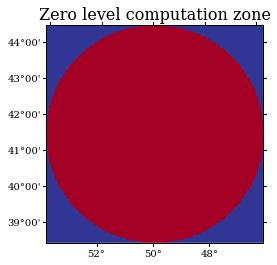

In [16]:
# Correct for the local background
ramap, decmap = map_tools.get_radec_map(header)
distance = map_tools.greatcircle(ramap, decmap, RA.to_value('deg'), Dec.to_value('deg'))
wzl = (distance > NR500ZL*C1.theta500.to_value('deg'))
zlmask = distance*0
zlmask[wzl] = 1
ZL = np.median(ymap_data[wzl])

# Show the map
fig = plt.figure(0, figsize=(5, 4))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(zlmask, origin='lower', cmap='RdYlBu')
plt.title('Zero level computation zone')

# Correction
ymap_data = ymap_data - ZL
print('Zero level correction: '+str(ZL))

### Get the model

In [17]:
for C in Clist:
    C.map_fov = ymap_fov
    C.map_reso = ymap_reso
    C.header = header

In [18]:
ymap_models = []
for C in Clist:
    ymap_model_im = C.get_sz_map(Compton_only=True)
    ymap_model_im = ndimage.gaussian_filter(ymap_model_im, sigma=FWHM2sigma*(FWHM_planck/ymap_reso).to_value(''), order=0)
    ymap_models.append(ymap_model_im)

### Profile

In [19]:
yprof_rad, yprof_data, yprof_err = map_tools.radial_profile_sb(ymap_data,   (RA.to_value('deg'), Dec.to_value('deg')), stddev=ymap_err,        header=header,binsize=yprof_reso.to_value('deg'))

yprof_models = []
for im in range(len(Clist)):
    yprof_model_im = map_tools.radial_profile_sb(ymap_models[im], (RA.to_value('deg'), Dec.to_value('deg')), stddev=ymap_models[im]*0+1, header=header, binsize=yprof_reso.to_value('deg'))[1]
    yprof_models.append(yprof_model_im)

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/ClusterTools/map_tools.py:575: RuntimeWarning: invalid value encountered in greater
  w_bin_val = (stddev > 0) * (np.isnan(stddev) == False) * (np.isnan(image) == False)


### Comparison

In [20]:
ymap_data   = ndimage.gaussian_filter(ymap_data, sigma=FWHM2sigma*(ymap_SM/xmap_reso).to_value(''), order=0)
for Y in ymap_models:
    Y = ndimage.gaussian_filter(Y, sigma=FWHM2sigma*(ymap_SM/xmap_reso).to_value(''), order=0)

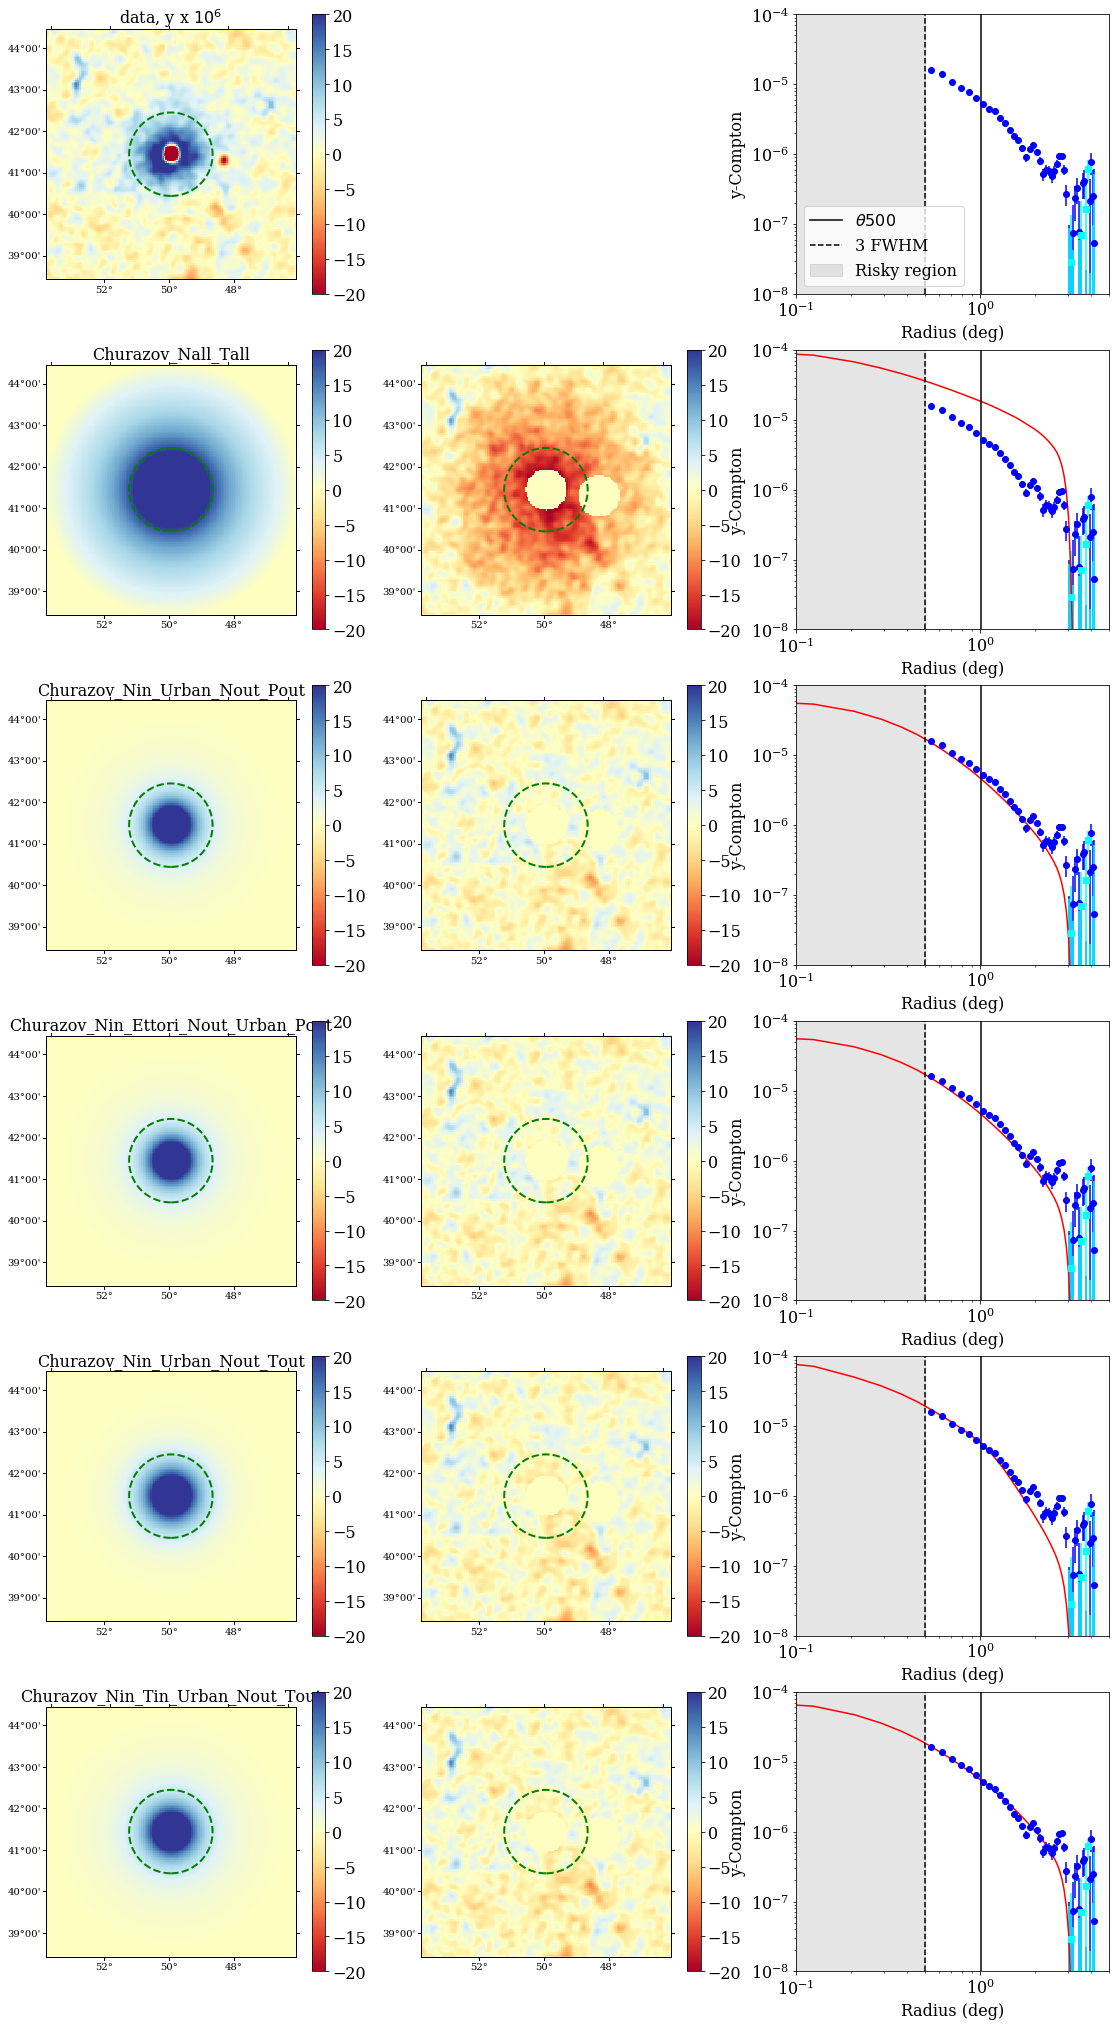

In [21]:
Ncol = 1+len(Clist)

fig = plt.figure(0, figsize=(18, Ncol*6))
#----- Data
ax = plt.subplot(Ncol, 3, 1, projection=WCS(header))
plt.imshow(1e6*ymap_data, vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
circle = matplotlib.patches.Ellipse((RA.value, Dec.value),2*C1.theta500.to_value('deg')/np.cos(Dec.value*np.pi/180), 2*C1.theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
ax.add_patch(circle)
plt.colorbar()
plt.title('data, y x $10^6$')

ax = plt.subplot(Ncol, 3, 3)
plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
plt.axvline(C1.theta500.to_value('deg'), color='k', label='$\\theta500$')
plt.axvline(NFWHMmask*FWHM_planck.to_value('deg'), color='k', linestyle='--', label=str(NFWHMmask)+' FWHM')
plt.fill_between([0,NFWHMmask*FWHM_planck.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
plt.ylim(1e-8,1e-4)
plt.xlim(1e-1,5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('y-Compton')
plt.legend()

#----- Models
im = 4
for imod in range(len(Clist)):
    ax = plt.subplot(Ncol,3,im, projection=WCS(header))
    plt.imshow(1e6*(ymap_models[imod]), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
    circle = matplotlib.patches.Ellipse((RA.value, Dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()
    plt.title(Clist[imod].name)

    ax = plt.subplot(Ncol,3,im+1, projection=WCS(header))
    plt.imshow(1e6*mask*(ymap_data-ymap_models[imod]), vmin=-20, vmax=20, origin='lower', cmap='RdYlBu')
    circle = matplotlib.patches.Ellipse((RA.value, Dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()

    ax = plt.subplot(Ncol, 3, im+2)
    plt.errorbar(yprof_rad, yprof_data, yprof_err, marker='o', linestyle='', color='blue')
    plt.errorbar(yprof_rad, -yprof_data, yprof_err, marker='s', linestyle='', color='cyan')
    plt.plot(yprof_rad, yprof_models[imod], marker='', linestyle='-', color='red')
    plt.axvline(Clist[imod].theta500.to_value('deg'), color='k')
    plt.axvline(NFWHMmask*FWHM_planck.to_value('deg'), color='k', linestyle='--')
    plt.fill_between([0,NFWHMmask*FWHM_planck.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
    plt.ylim(1e-8,1e-4)
    plt.xlim(1e-1,5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius (deg)')
    plt.ylabel('y-Compton')
    
    im = im + 3

# Comparison to RASS

### Get the data

In [22]:
xmap_data, header = map_tools.roi_extract_healpix(xmap_file, RA.value, Dec.value, xmap_reso.to_value('deg'), [xmap_fov.to_value('deg'), xmap_fov.to_value('deg')],visu=False)
xmap_data = xmap_data*xmap_coeff*(1*u.arcmin**-2).to_value('deg-2')

In [23]:
# Compute the rms
xmap_err = xmap_data*0 + np.std(xmap_data)
for i in [1,2,3,4,5]: 
    xmap_err = xmap_data*0 + np.std(xmap_data[np.abs(xmap_data/xmap_err) < 3])    
print('Median rms = '+str(np.nanmedian(xmap_err)))

Median rms = 1.4085933718641295


Zero level correction: 2.2182015161618756


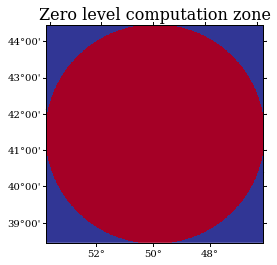

In [24]:
# Correct for the local background
ramap, decmap = map_tools.get_radec_map(header)
distance = map_tools.greatcircle(ramap, decmap, RA.to_value('deg'), Dec.to_value('deg'))
wzl = (distance > NR500ZL*C1.theta500.to_value('deg'))
zlmask = distance*0
zlmask[wzl] = 1
ZL = np.median(xmap_data[wzl])

# Show the map
fig = plt.figure(0, figsize=(5, 4))
ax = plt.subplot(111, projection=WCS(header))
plt.imshow(zlmask, origin='lower', cmap='RdYlBu')
plt.title('Zero level computation zone')

# Correction
if ~np.isnan(ZL):
    xmap_data = xmap_data - ZL
print('Zero level correction: '+str(ZL))

### Get the model

In [25]:
for C in Clist:
    C.map_fov = xmap_fov
    C.map_reso = xmap_reso
    C.header = header

In [26]:
xmap_models = []
for C in Clist:
    C.make_xspec_table(Emin=xmap_band[0], Emax=xmap_band[1], Tmin=0.1*u.keV, Tmax=15.0*u.keV, nbin=10,file_HI=xmap_nh_file, visu_nH=False, model='APEC',resp_file=xmap_resp_file, data_file=xmap_sp_file, app_nH_model=False)
    xmap_model_im = C.get_xray_map(output_type='R').to_value('s-1 deg-2')
    xmap_model_im = ndimage.gaussian_filter(xmap_model_im, sigma=FWHM2sigma*(FWHM_rass/xmap_reso).to_value(''), order=0)
    xmap_models.append(xmap_model_im)

<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.
<type 'numpy.ndarray'>
!!! WARNING, nH is not well constrain in the field:
mean/rms < 5 and nH=0.1389964530343819 10^22 cm-2.


### Profile

In [27]:
xprof_rad, xprof_data, xprof_err = map_tools.radial_profile_sb(xmap_data, (RA.to_value('deg'), Dec.to_value('deg')), stddev=xmap_err, header=header,binsize=xprof_reso.to_value('deg'))

xprof_models = []
for im in range(len(Clist)):
    xprof_model_im = map_tools.radial_profile_sb(xmap_models[im], (RA.to_value('deg'), Dec.to_value('deg')), stddev=xmap_models[im]*0+1, header=header, binsize=xprof_reso.to_value('deg'))[1]
    xprof_models.append(xprof_model_im)

### Comparison

In [28]:
xmap_data   = ndimage.gaussian_filter(xmap_data, sigma=FWHM2sigma*(xmap_SM/xmap_reso).to_value(''), order=0)
for X in xmap_models:
    X = ndimage.gaussian_filter(X, sigma=FWHM2sigma*(xmap_SM/xmap_reso).to_value(''), order=0)

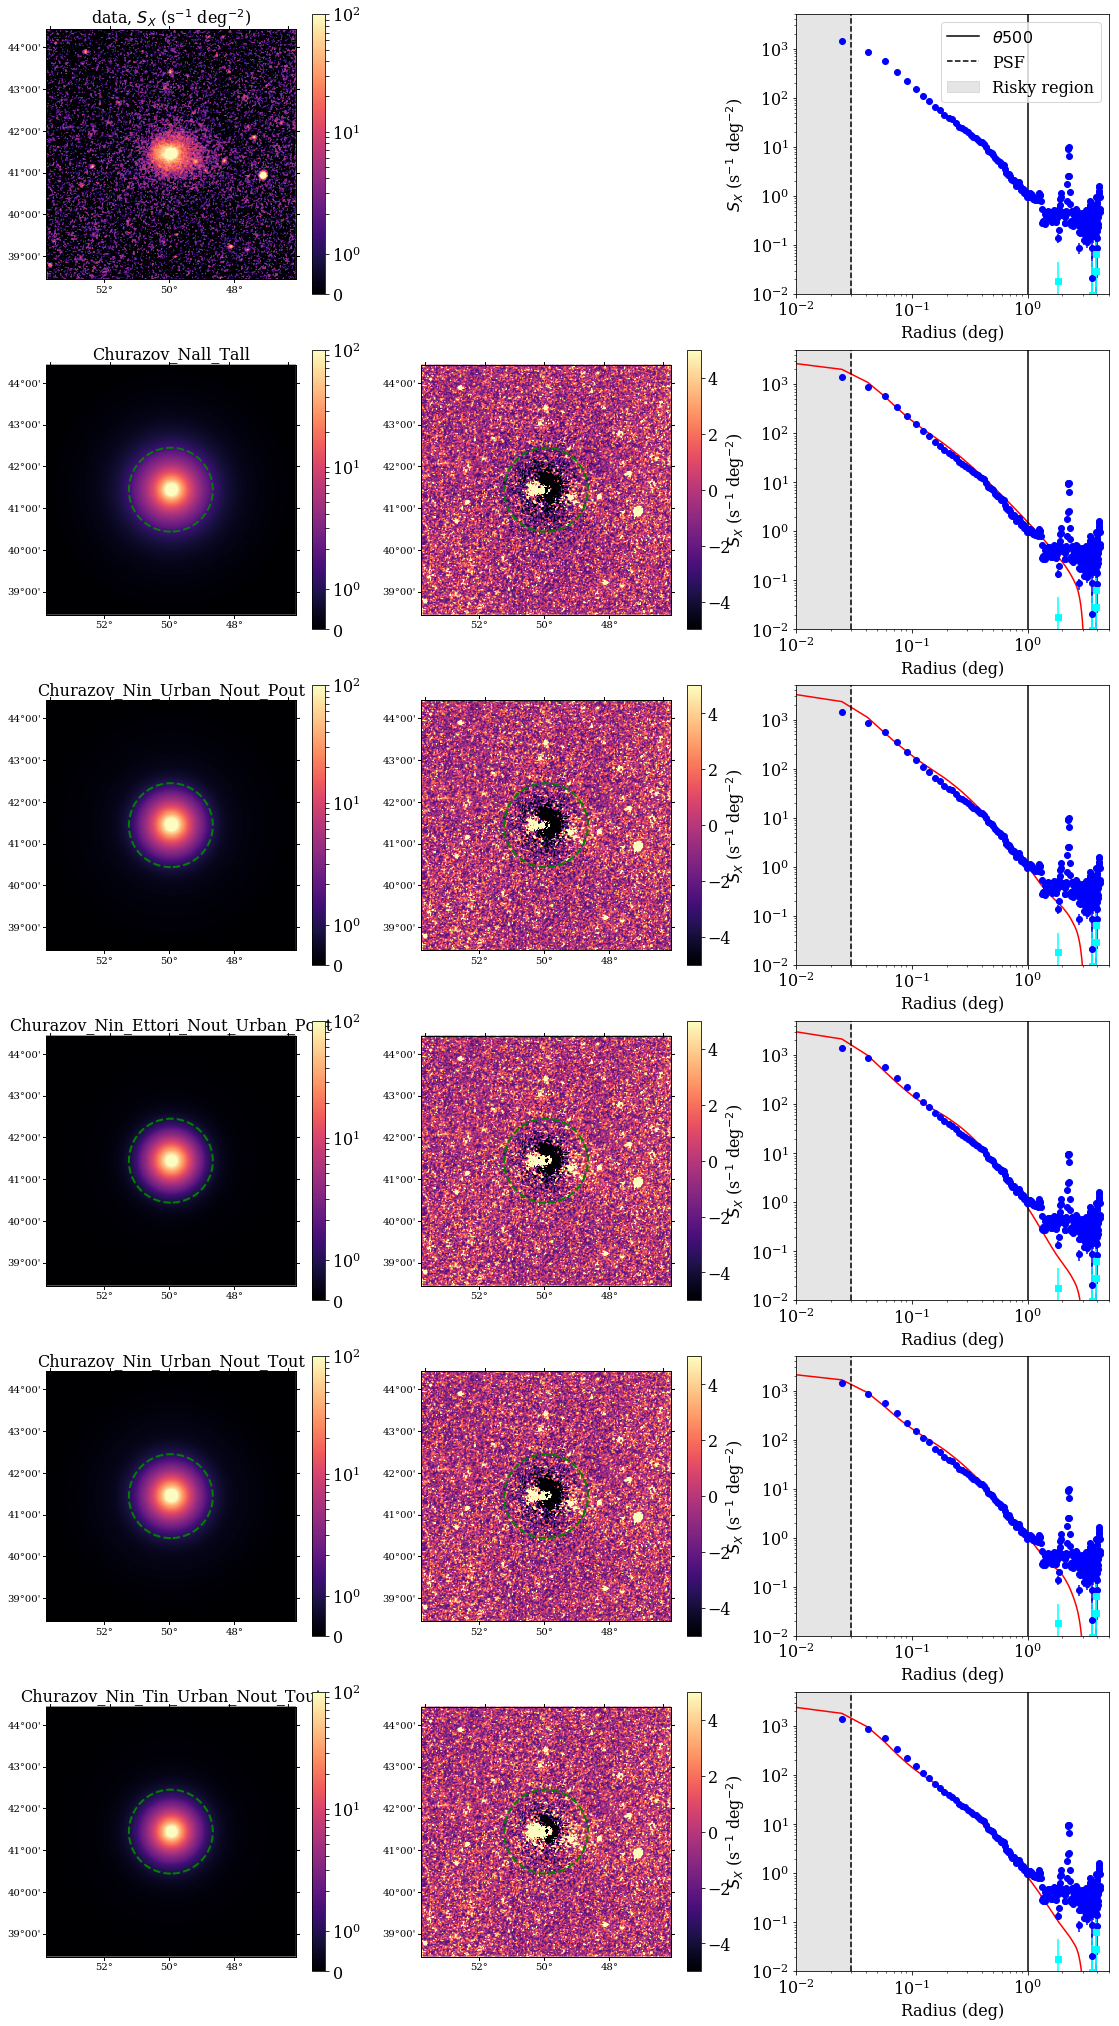

In [30]:
Ncol = 1+len(Clist)

fig = plt.figure(0, figsize=(18, Ncol*6))
#----- Data
ax = plt.subplot(Ncol, 3, 1, projection=WCS(header))
plt.imshow(xmap_data, origin='lower', cmap='magma', norm=SymLogNorm(2e0, vmin=0, vmax=1e2))
plt.colorbar()
plt.title('data, $S_X$ (s$^{-1}$ deg$^{-2}$)')

ax = plt.subplot(Ncol, 3, 3)
plt.errorbar(xprof_rad, xprof_data, xprof_err, marker='o', linestyle='', color='blue')
plt.errorbar(xprof_rad, -xprof_data, xprof_err, marker='s', linestyle='', color='cyan')
plt.axvline(C1.theta500.to_value('deg'), color='k', label='$\\theta500$')
plt.axvline(FWHM_rass.to_value('deg'), color='k', linestyle='--', label='PSF')
plt.fill_between([0,FWHM_rass.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
plt.ylim(1e-2,5e3)
plt.xlim(1e-2,5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (deg)')
plt.ylabel('$S_X$ (s$^{-1}$ deg$^{-2}$)')
plt.legend()

#----- Model 1
im = 4
for imod in range(len(Clist)):
    ax = plt.subplot(Ncol,3,im, projection=WCS(header))
    plt.imshow(xmap_models[imod], origin='lower', cmap='magma', norm=SymLogNorm(2e0, vmin=0, vmax=1e2))
    circle = matplotlib.patches.Ellipse((RA.value, Dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()
    plt.title(Clist[imod].name)

    ax = plt.subplot(Ncol,3,im+1, projection=WCS(header))
    plt.imshow(xmap_data-xmap_models[imod], vmin=-5, vmax=5, origin='lower', cmap='magma')
    circle = matplotlib.patches.Ellipse((RA.value, Dec.value),2*Clist[imod].theta500.to_value('deg')/np.cos(Dec.value*np.pi/180), 2*Clist[imod].theta500.to_value('deg'),linewidth=2, fill=False, zorder=2,edgecolor='green', linestyle='dashed',facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(circle)
    plt.colorbar()

    ax = plt.subplot(Ncol, 3, im+2)
    plt.errorbar(xprof_rad, xprof_data, xprof_err, marker='o', linestyle='', color='blue')
    plt.errorbar(xprof_rad, -xprof_data, xprof_err, marker='s', linestyle='', color='cyan')
    plt.plot(xprof_rad, xprof_models[imod], marker='', linestyle='-', color='red')
    plt.axvline(Clist[imod].theta500.to_value('deg'), color='k')
    plt.axvline(FWHM_rass.to_value('deg'), color='k', linestyle='--', label='PSF')
    plt.fill_between([0,FWHM_rass.to_value('deg')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Risky region')
    plt.ylim(1e-2,5e3)
    plt.xlim(1e-2,5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Radius (deg)')
    plt.ylabel('$S_X$ (s$^{-1}$ deg$^{-2}$)')

    im = im + 3